# **_Chess Piece Classification_**

### __*This CNN is supposed to determine what kind of Chess Piece is in the Image*__

<br>

### __*Import Libraries and choose the device*__

In [1]:
# Import of the Libraries
import os
import CNN

# Torch libraries
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Device config
GPU = CNN.pick_device()

Using the Graphics Card


<br>

### __*Training Preparation (Set all variables here)*__

In [0]:
# Hyper-parameters
num_epochs = 25         # How many times to repeat learning
batch_size = 8          # Number of images to send at once
learning_rate = 0.001    # How quickly should it learn

# Image Dimensions
IMG_SIZE = 85           # 85*85 pixels
COLOUR_SIZE = 1

# Define the directory
FILE_PATH = './data/chess/pieces'           # Sub-Folders Location
CSV_PATH = './data/chess/data.csv'          # CSV Location
TRAIN_CSV = './data/chess/train_data.csv'   # Train CSV Location
TEST_CSV = './data/chess/test_data.csv'     # Test CSV Location
CATEGORIES = os.listdir(FILE_PATH)          # Turn Sub-Folder names into a list
N_CLASSES = len(CATEGORIES)                 # Number of different classes

# Create the Model
model = CNN.model.ConvNet(COLOUR_SIZE, N_CLASSES).to(GPU)

# Choose type of Loss & Optimization function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

<br>

### __*Dataset Creation*__

In [2]:
# Normalized Transformation
MEAN, STD = CNN.dataset.get_normal(FILE_PATH, IMG_SIZE, IMG_SIZE)
trans_normal = CNN.dataset.trans_normal(IMG_SIZE, IMG_SIZE, MEAN, STD)

# Create the .csv file & dictionary
indexing = CNN.dataset.create_csv(FILE_PATH, train_csv=TRAIN_CSV, test_csv=TEST_CSV,
                      rewrite=True, split=True, test_ratio=0.2, mul=4)

# Create the Datasets
train_dataset = CNN.dataset.CustomDataset(FILE_PATH, TRAIN_CSV, transform=trans_normal)
test_dataset = CNN.dataset.CustomDataset(FILE_PATH, TEST_CSV, transform=trans_normal)

# Create the DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

#### __*Look at some data*__

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


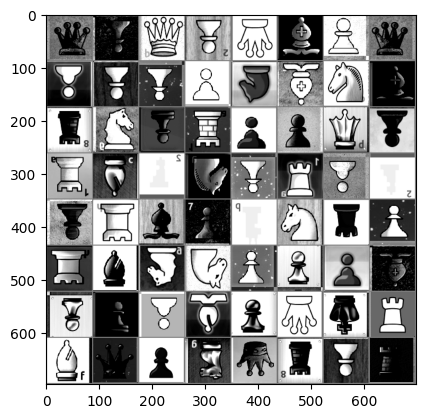

Batch size: 64 | Colour size: 1 | Image Size: 85*85 pixels


,Class,Train Data,Test Data,Total
0,king,112,6,118
1,pawn,768,47,815
2,rook,232,14,246
3,queen,112,6,118
4,bishop,216,13,229
5,knight,228,14,242
,,,,
T:,6,1668,100,1768


In [3]:
# Get dataset overview
CNN.visual.overview(train_dataset, test_dataset, indexing)

<br>

### __*Training Loop*__

Epoch 1 / 25 | Step 209 / 209 | Loss: 0.0771
Epoch 2 / 25 | Step 209 / 209 | Loss: 0.0204
Epoch 3 / 25 | Step 209 / 209 | Loss: 0.0092
Epoch 4 / 25 | Step 209 / 209 | Loss: 0.0045
Epoch 5 / 25 | Step 209 / 209 | Loss: 0.0045
Epoch 6 / 25 | Step 209 / 209 | Loss: 0.0018
Epoch 7 / 25 | Step 209 / 209 | Loss: 0.0008
Epoch 8 / 25 | Step 209 / 209 | Loss: 0.0049
Epoch 9 / 25 | Step 209 / 209 | Loss: 0.0045
Epoch 10 / 25 | Step 209 / 209 | Loss: 0.0015
Epoch 11 / 25 | Step 209 / 209 | Loss: 0.0008
Epoch 12 / 25 | Step 209 / 209 | Loss: 0.0049
Epoch 13 / 25 | Step 209 / 209 | Loss: 0.0005
Epoch 14 / 25 | Step 209 / 209 | Loss: 0.0002
Epoch 15 / 25 | Step 209 / 209 | Loss: 0.0004
Epoch 16 / 25 | Step 209 / 209 | Loss: 0.0005
Epoch 17 / 25 | Step 209 / 209 | Loss: 0.0003
Epoch 18 / 25 | Step 209 / 209 | Loss: 0.0000
Epoch 19 / 25 | Step 209 / 209 | Loss: 0.0000
Epoch 20 / 25 | Step 209 / 209 | Loss: 0.0000
Epoch 21 / 25 | Step 209 / 209 | Loss: 0.0000
Epoch 22 / 25 | Step 209 / 209 | Loss: 0.00

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Class: bishop | Predicted: king


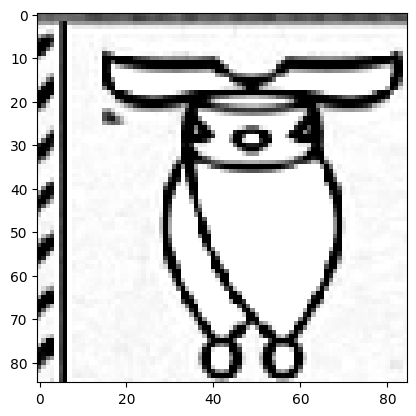

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Class: knight | Predicted: queen


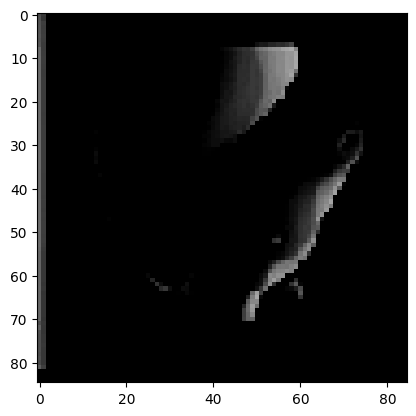

Accuracy of the Model: 98.00 %
Accuracy of king: 100.00 %
Accuracy of pawn: 100.00 %
Accuracy of rook: 100.00 %
Accuracy of queen: 100.00 %
Accuracy of bishop: 92.31 %
Accuracy of knight: 92.86 %


In [4]:
# Train the Model
CNN.model.train_model(model, train_loader, criterion, optimizer, num_epochs, device=GPU)

# Save the Model
SAVE_PATH = './data/chess/chess.pth'
CNN.model.save(model, SAVE_PATH)

# Test the Model
res = CNN.model.load_model(model, test_loader, CATEGORIES, show_wrongs=True)